<a href="https://colab.research.google.com/github/antoinexp/markov-chains-COM-516/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is provided as a starting point to help you generate random instances G1 and G2 as mentioned in the handout.

You are free to use and modify it at your own convenience.

---



In [1]:
import scipy.stats as st
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
class DatasetGenerator(object):
  def __init__(self, N=100):
    self.N = N
    self.x = None
    self.v = None
    self.refresh()
  
  def refresh(self):
    raise Exception("undefined")

In [3]:
class G1(DatasetGenerator):
  def refresh(self):
    self.x = st.uniform().rvs((self.N,2))
    self.v = st.uniform().rvs((self.N,))

In [4]:
class G2(DatasetGenerator):
  def refresh(self):
    self.x = st.uniform().rvs((self.N,2))
    self.v = np.exp(st.norm(-0.85, 1.3).rvs((self.N,)))

### Uniform distribution ($\mathcal U([0,1])$)

In [5]:
g1 = G1()

Examples:

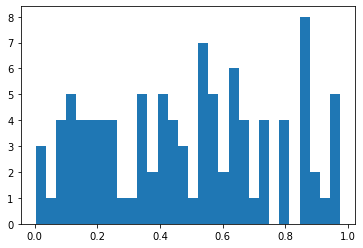

In [6]:
# Plot a histogram of the v array
plt.hist(g1.v, bins=30)
plt.show()

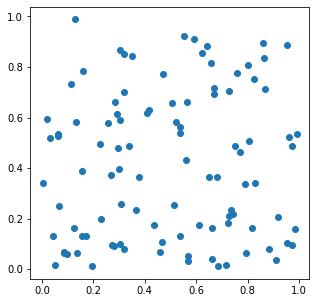

In [7]:
# plot the position of the points
plt.figure(figsize=(5,5))
plt.scatter(g1.x[:,0], g1.x[:,1])
plt.show()

You can refresh the dataset

In [8]:
g1.refresh() # generate a new dataset

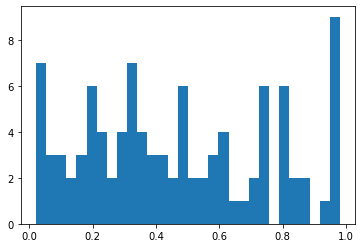

In [9]:
plt.hist(g1.v, bins=30)
plt.show()

Or for instance, you can generate 10 instances and compute the average position of all the points:

In [10]:
m = np.array([0., 0.])

for _ in range(10):
  g1.refresh() # refresh the dataset
  m  += 0.1*g1.x.mean()

print(m)

[0.48746476 0.48746476]


### Test on log-normal distribution

In [11]:
g2 = G2()

Example:

you can use g2 to generate an instance of the lognormal distribution

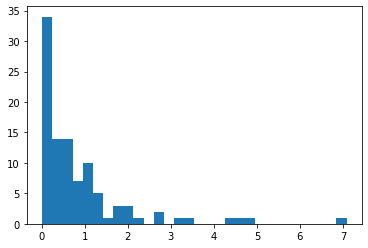

In [12]:
plt.hist(g2.v, bins=30)
plt.show()

In [13]:
g2.refresh() # to generate a new x and v

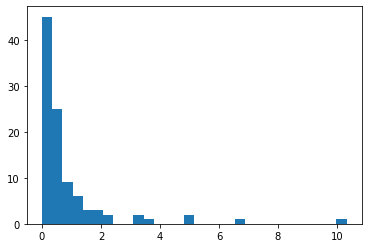

In [14]:
plt.hist(g2.v, bins=30)
plt.show()

---

### Metropolis Hastings

### **1. Implementation**

Implementation of Metropolis-Hastings algorithm to find an approximate solution of $S^*(\lambda)$

**Libraries**

In [35]:
import numpy as np
import copy
import time
from scipy.spatial import distance

**Definition of the objective function**

In [16]:
def f(S, params):
    """
    Compute the objective function (that we want to maximize).
    
    Parameters
    ----------
    S: Subset of P({1,...,n}) as an array of shape (k,) with k an int in [1,n]
    params: tuple containing the fixed value of the deployment cost lambda_, as well as the fixed value of cities n. 
    It also contains an (n,2) array coords containing for each cities its coordinates and another (n,) array  pop with respective population.
    
    Returns
    -------
    f: The evaluated objective function.
    """
    
    lambda_, n, coords, pop = params
    
    #only consider coordinates of cities in S (the -1 is here because indexes start at 0 and the cities at 1, so the i-th cities is on the i-1th row)
    coords_S = coords[S-1]
    pop_S = pop[S-1]

    return np.sum(pop_S) - lambda_ * n * np.pi * (np.max(distance.cdist(coords_S, coords_S, 'euclidean')))**2 / 4

**Metropolis-Hastings algorithm**

The function we want to maximize is defined on $f : P[1,n] \rightarrow \mathbb{R}$.
To achieve this, we will minimize g defined as -f.

In [17]:
def g(S, params):
    return -f(S, params)

**a) Definition of the base chain**

We choose a Random Walk on the hypercube $C = \{0,1\}^n$. States are therefore notated as vectors x of dimension n filled with 0's and 1's.

Vocabulary: we will say that x and y are neighbours if the two vectors differ by only one digit. Example: (1,0,1,0,0) and (1,0,1,1,0) are neighbours but (1,0,1,0,0) and (1,0,1,1,1) are not.

The transition matrix is the following:
$$
\psi_{xy} = \left\{
    \begin{array}{ll}
        \frac{1}{n+1} & \mbox{if x and y are neighbours or } x = y  \\
        0 & \mbox{otherwise.}
    \end{array}
\right.
$$

Defined like this, it has all the necessary hypothesis to be a base chain: 
- irreducible
- aperiodic
- $\psi_{xy} > 0$ iff $\psi_{yx} > 0$

The idea behind taking this base chain is that a vector x of dimension n describe perfectly (meaning: without ambiguity) one set of cities S taken in $P[1,n]$.

For instance, for $n = 5$, $x = np.array([1,0,0,1,1])$ correspond to $S = \{1,4,5\}$. If the i-th digit in x is 1, it means that the i-th city is in S, if the i-th digit in x is 0, it means that the i-th city is not in S.

As a result, in the computation of the acceptance probabilities, computing g(x) will be interpreted as computing g(S) with S being the corresponding set of cities (as explained just before).

Our aim is to sample from the distribution $\pi_{\infty}(x) = \frac{\mathbb{1}_{x\ is\ a\ global\ minimum\ of\ g}}{Z_{\infty}}$.

But this is a difficult task, this is why me sample from the distribution $\pi_{\beta}$ instead $\pi_{\beta}(x) = \frac{e^{-\beta g(x)}}{Z_{\beta}}$.

But this is still difficult because of $Z_{\beta}$. This is why we will construct a Markov chain having $\pi_{\beta}$ as its stationary distribution using the Metropolis-Hastings algorithm.

**b) Definition of the acceptance probabilities**

Because if  $\psi_{xy} = \psi_{yx} = 0$ then $\frac{0}{0} = 0$ and that in any other case, $\frac{\psi_{xy}}{\psi_{yx}} = 1$, we can express the acceptance probabilities  as follows:

$$
a_{xy} = min(1, \frac{\pi_{\beta}(y)}{\pi_{\beta}(x)}) =\left\{
    \begin{array}{ll}
        min(1, e^{-\beta (g(y) - g(x))}) & \mbox{if x and y are neighbours}  \\
        0 & \mbox{otherwise.}
    \end{array}
\right.
$$


Note that here, the ${Z_{\beta}}$ cancels out in the acceptance probabilities computation (this is why we used the Metropolis-Hastings algorithm to begin with).


In [18]:
def vect_to_S(x):
    """
    Compute the subset S of cities corresponding to the vector encoding
    
    Parameters
    ----------
    x: ndarray of shape (n,)
    
    Returns
    -------
    S: the subset of corresponding cities
    """
    
    return np.argwhere(x).flatten() + 1

#vect_to_S(np.array([1,0,1,0,1,0,1,1,1]))

In [19]:
def is_neighbour(x,y):
    """
    Find out if x and y are neighbours
    
    Parameters
    ----------
    x: ndarray of shape (n,)
    y: ndarray of shape (n,)
    
    Returns
    -------
    Bool: True if they are neighbours, False otherwise
    """

    if np.sum(x != y) == 1:
        return True
    
    return False
    
#is_neighbour(np.array([1,0,1,0,1,0,1,1,1]), np.array([0,0,1,0,1,0,1,1,1]))

In [20]:
def psi_xy(x, y, bool_is_neighbour):
    """
    Compute the base chain transition probabilities
    
    Parameters
    ----------
    x: ndarray of shape (n,)
    y: ndarray of shape (n,)
    bool_is_neighbour: Boolean (True is x is a neighbour of y, False otherwise)
    
    Returns
    -------
    psi_xy: 1/n+1 if x=y or x in a neighbour of y, 0 otherwise
    """
    
    n = len(x)
    
    if (x == y).all() or bool_is_neighbour:
        return 1/(n+1)
    
    return 0

In [21]:
def a_xy(beta, x, y, bool_is_neighbour, params):
    """
    Compute the acceptance probabilities defined as min(1, pi_[j]*psi[j,i]/(pi_[i]*psi[i,j]))
    
    Parameters
    ----------
    beta: float
    x: ndarray of shape (n,)
    y: ndarray of shape (n,)
    bool_is_neighbour: Boolean (True is x is a neighbour of y, False otherwise)
    params: tuple containing the fixed value of the deployment cost lambda_, as well as the fixed value of cities n. 
    It also contains an (n,2) array coords containing for each cities its coordinates and another (n,) array  pop with respective population.
    
    Returns
    --------
    a_xy: The acceptance probability corresponding to going from state x to y
    """
    
    if bool_is_neighbour:
        S_x = vect_to_S(x)
        S_y = vect_to_S(y)
        
        g_x = g(S_x, params)
        g_y = g(S_y, params)
        
        return min(1, np.exp(-beta*(g_y - g_x)))
    
    else:
        return 0

#a_xy(3, np.array([1,0,1,0,1,0,1,1,1]), np.array([0,0,1,0,1,0,1,1,1]), params)
#a_xy(3, np.array([1,0,1,1,1,0,1,1,1]), np.array([0,0,1,0,1,0,1,1,1]), params)

**c) Constructing the new chain**

The transition probabilities of the new chain is defined as follows:

$$
p_{xy} = \left\{
    \begin{array}{ll}
        \psi_{xy}a_{xy} & \mbox{if } x \ne y  \\
        1 - \sum_{v\ne x}\psi_{xv}a_{xv} & x = y
    \end{array}
\right.
$$

Because $a_{xv} = 0$ when v is not a neighbour of y, the sum can be simplified. Let us note $A_x = \{y \in C | is\_neighbour(x,y) == True\}$, then:

$$
p_{xy} = \left\{
    \begin{array}{ll}
        \psi_{xy}a_{xy} & \mbox{if } x \ne y  \\
        1 - \sum_{v \in A_x}\psi_{xv}a_{xv} & x = y
    \end{array}
\right.
$$

Which is way easier to compute because the sum has now only n terms in it!

It can be even more simplified if we write like this:

$$
p_{xy} = \left\{
    \begin{array}{ll}
        \psi_{xy}a_{xy} & \mbox{if x and y are neighbours} \\
        1 - \sum_{v \in A_x}\psi_{xv}a_{xv} & \mbox{if } x = y \\
        0 & \mbox{otherwise.}
    \end{array}
\right.
$$

Such a constructed chain will have the following property: $p_{xy}(n) \xrightarrow[n \to \infty]{} \pi_{\beta}(y)$ $\forall y$ in $C$

In [22]:
def A_set(x):
    """
    Compute, for a vector x, all its neighbours
    
    Parameters
    ----------
    x: ndarray of shape (n,)
    
    Returns
    A: list of all neighbours of x
    """
    
    A_x = []
    
    for i in range(len(x)):
        x_neighbour = x.copy()
        x_neighbour[i] = (x[i] + 1) % 2
        A_x.append(x_neighbour)
    return A_x

#print(A_set(np.array([1,0,1,1])))

In [23]:
def p_xy(beta,x,y,params):
    """
    Computes the transition probabilities of the new chain.
    
    Parameters
    ----------
    beta: float
    x: ndarray of shape (n,)
    y: ndarray of shape (n,)
    params: tuple containing the fixed value of the deployment cost lambda_, as well as the fixed value of cities n. 
    It also contains an (n,2) array coords containing for each cities its coordinates and another (n,) array  pop with respective population.
    
    Returns
    -------
    p_xy: Transition probabilities of the new chain
    """
    
    bool_ = is_neighbour(x,y)
    
    if bool_:
        return psi_xy(x,y,bool_) * a_xy(beta, x, y, bool_, params)
    
    elif (x == y).all():
        A_x = A_set(x)
        return 1 - np.sum([psi_xy(x,v,True)*a_xy(beta,x,v,True, params) for v in A_x])
    
    else:
        return 0

In [24]:
def forward(beta,x,params):
    """
    Apply one step of the Metropolis_Hastings algorithm
    
    Parameters
    ----------
    beta: float
    x: ndarray of shape (n,)
    params: tuple containing the fixed value of the deployment cost lambda_, as well as the fixed value of cities n. 
    It also contains an (n,2) array coords containing for each cities its coordinates and another (n,) array  pop with respective population.
    
    Returns
    -------
    y: A state picked in the list of neighbours A_x or itself (loop) according to propabilities p_xy.
    """
    
    n = len(x)
    A_x = A_set(x) + [x]
    p_xA = []
    
    for elem in A_x:
        p_xA.append(p_xy(beta,x,elem,params))
        
    return A_x[np.random.choice(n+1, p = p_xA)]

#y = forward(1, x1, params)
#print(is_neighbour(x1,y))
#print((x1==y).all())

**Tuning of $\beta$**

- Start with $\beta$ small (i.e. high temperature regime):  the algorithm will then visit all the states of C quite uniformly at the beginning. After a sufficiently high number of iterations, the Metropolized chain is roughly distributed as $\pi_{\beta}$.
- Increase then $\beta$(i.e. lower the temperature) and rerun the algorithm from the state found in the previous step.
- Repeat step 2 until $\beta$ is sufficiently large, so that one can be quite sure (i.e. with prob.  1−$\epsilon$) to have reached a global minimum.

In [40]:
def metropolis_hastings(betas, n_iter, params):
    """
    Follow the Tuning beta procedure:
    - Start with $\beta$ small (i.e. high temperature regime):  the algorithm will then visit all the states of C quite uniformly at the beginning. After a sufficiently high number of iterations, the Metropolized chain is roughly distributed as $\pi_{\beta}$.
    - Increase then $\beta$(i.e. lower the temperature) and rerun the algorithm from the state found in the previous step.
    - Repeat step 2 until $\beta$ is sufficiently large, so that one can be quite sure (i.e. with prob.  1−$\epsilon$) to have reached a global minimum.
    
    Parameters
    ----------
    betas: list of increasing beta (floats)
    n_iter: int, number of iteration for each temperature
    params: tuple containing the fixed value of the deployment cost lambda_, as well as the fixed value of cities n. 
    It also contains an (n,2) array coords containing for each cities its coordinates and another (n,) array  pop with respective population.
    
    Returns
    -------
    S^*(lambda)_approx: the approximation of the optimizing set.
    """
    x = np.random.randint(0,2,100)

    #We decrease the temperature little bit by little bit
    for beta in betas:
        start = time.time()
        #At each temperature we do n_iter number of iterations so that the Metropolized chain is rougly distributed as pi_beta
        for n in range(n_iter):
            x = forward(beta,x,params)
        print("Time spent on beta = {:.3f} : {:.3f} sec".format(beta,time.time()-start))
    return vect_to_S(x)

For question 2.a.

In [26]:
def plot_a():
    """
    Plots the evolution of the objective function 
    """
    return
    

For question 2.b.

In [27]:
def plot_b():
    return

### **2. Testing the implementation** 

Generate G_1 according to the generative model G1

In [28]:
G_1 = G1()

In [29]:
"Testing the transition probabilities"

lambda_ = 0.5
n = 100
coords = G_1.x
pop = G_1.v

params = (lambda_, n, coords, pop)

np.random.seed(0)
x1 = np.random.randint(0,high = 2, size = 100)
x2 = x1.copy()
x2[56] = (x1[56] + 1)%2

x3 = np.random.randint(0,high = 2, size = 100)

print(p_xy(2, x1, x3, params)) #example where x and y are not neighbours ---> expected 0
print(p_xy(2, x1, x2, params)) #example where x and y are neighbours
print(p_xy(2, x1, x1, params)) #example where x = y

0
0.004556990215295341
0.2671287808837809


In [30]:
"""Testing g"""

S_test = np.array([0,8,55,96])
lambdas_ = np.linspace(0,1,11)

for lambda_ in lambdas_:
    params = (lambda_, n, coords, pop)
    g_eval = g(S_test, params)
    print(g_eval)

-1.888229356171545
6.23703795788583
14.362305271943205
22.48757258600058
30.612839900057953
38.73810721411533
46.86337452817271
54.98864184223008
63.113909156287455
71.23917647034483
79.3644437844022


In [42]:
"""Testing the metropolis-hasting function"""

betas = np.logspace(0,3,7)

G_1 = G1()
lambda_ = 0
n = 100
coords = G_1.x
pop = G_1.v
n_iter = 100

params = (lambda_, n, coords, pop)

S_approx = metropolis_hastings(betas,n_iter,params)

print(S_approx)
print(len(S_approx))

#find all 100 cities ---> which is what we want because lambda = 0! 
#Sometimes finds 99 cities which is almost what we want (not enough iterations?)

Time spent on beta = 1.000 : 3.111 sec
Time spent on beta = 3.162 : 3.467 sec
Time spent on beta = 10.000 : 3.960 sec
Time spent on beta = 31.623 : 4.491 sec
Time spent on beta = 100.000 : 4.770 sec
Time spent on beta = 316.228 : 4.821 sec
Time spent on beta = 1000.000 : 4.828 sec
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
100


In [43]:
"""Testing the metropolis-hasting function with 10 times more iterations"""

betas = np.logspace(0,3,7)

G_1 = G1()
lambda_ = 0
n = 100
coords = G_1.x
pop = G_1.v
n_iter = 1000

params = (lambda_, n, coords, pop)

S_approx = metropolis_hastings(betas,n_iter,params)

print(S_approx)
print(len(S_approx))

Time spent on beta = 1.000 : 34.072 sec
Time spent on beta = 3.162 : 37.424 sec
Time spent on beta = 10.000 : 44.367 sec
Time spent on beta = 31.623 : 45.998 sec
Time spent on beta = 100.000 : 47.559 sec
Time spent on beta = 316.228 : 50.833 sec
Time spent on beta = 1000.000 : 48.717 sec
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
100


In [44]:
"""Testing the metropolis-hasting function 1000 iterations and lambda = 0.5"""

betas = np.logspace(0,3,7)

G_1 = G1()
lambda_ = 0.5
n = 100
coords = G_1.x
pop = G_1.v
n_iter = 1000

params = (lambda_, n, coords, pop)

S_approx = metropolis_hastings(betas,n_iter,params)

print(S_approx)
print(len(S_approx))

Time spent on beta = 1.000 : 30.845 sec
Time spent on beta = 3.162 : 35.004 sec
Time spent on beta = 10.000 : 37.489 sec
Time spent on beta = 31.623 : 39.573 sec
Time spent on beta = 100.000 : 39.707 sec
Time spent on beta = 316.228 : 41.208 sec
Time spent on beta = 1000.000 : 39.813 sec
[  1   2   3   6   7   8   9  10  11  12  13  14  16  18  20  21  22  23
  24  25  26  28  29  30  31  32  33  34  35  36  38  40  41  42  43  44
  46  47  48  49  50  51  52  53  54  55  56  57  60  61  62  63  65  66
  67  68  69  72  73  74  75  76  78  79  80  83  84  85  86  87  88  90
  91  92  93  94  95  96  97  98  99 100]
82


In [46]:
"""Testing the metropolis-hasting function 1000 iterations and lambda = 1"""

betas = np.logspace(0,3,7)

G_1 = G1()
lambda_ = 1
n = 100
coords = G_1.x
pop = G_1.v
n_iter = 1000

params = (lambda_, n, coords, pop)

S_approx = metropolis_hastings(betas,n_iter,params)

print(S_approx)
print(len(S_approx))

Time spent on beta = 1.000 : 30.091 sec
Time spent on beta = 3.162 : 31.525 sec
Time spent on beta = 10.000 : 34.955 sec
Time spent on beta = 31.623 : 36.107 sec
Time spent on beta = 100.000 : 37.027 sec
Time spent on beta = 316.228 : 37.172 sec
Time spent on beta = 1000.000 : 37.314 sec
[  2   4   6   7   8   9  11  12  13  14  16  18  19  20  21  22  24  25
  26  27  28  29  30  32  33  34  35  36  37  38  39  40  42  43  44  45
  46  47  48  49  50  52  53  55  57  58  59  62  63  64  65  66  67  68
  69  70  71  72  73  74  76  77  78  79  80  81  83  85  88  89  90  91
  92  94  95  97  99 100]
78


In [47]:
"""Testing the metropolis-hasting function 1000 iterations and lambda = 0 on the G2 model"""

betas = np.logspace(0,3,7)

G_2 = G2()
lambda_ = 0
n = 100
coords = G_2.x
pop = G_2.v
n_iter = 1000

params = (lambda_, n, coords, pop)

S_approx = metropolis_hastings(betas,n_iter,params)

print(S_approx)
print(len(S_approx))

Time spent on beta = 1.000 : 33.753 sec
Time spent on beta = 3.162 : 38.123 sec
Time spent on beta = 10.000 : 43.740 sec
Time spent on beta = 31.623 : 45.519 sec
Time spent on beta = 100.000 : 46.818 sec
Time spent on beta = 316.228 : 47.285 sec
Time spent on beta = 1000.000 : 47.183 sec
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
100


In [48]:
"""Testing the metropolis-hasting function 1000 iterations and lambda = 0.5 on the G2 model"""

betas = np.logspace(0,3,7)

G_2 = G2()
lambda_ = 0.5
n = 100
coords = G_2.x
pop = G_2.v
n_iter = 1000

params = (lambda_, n, coords, pop)

S_approx = metropolis_hastings(betas,n_iter,params)

print(S_approx)
print(len(S_approx))

Time spent on beta = 1.000 : 31.676 sec
Time spent on beta = 3.162 : 33.714 sec
Time spent on beta = 10.000 : 37.073 sec
Time spent on beta = 31.623 : 39.647 sec
Time spent on beta = 100.000 : 40.392 sec
Time spent on beta = 316.228 : 40.558 sec
Time spent on beta = 1000.000 : 40.636 sec
[  1   2   3   4   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  23  25  26  27  28  29  30  32  33  35  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  77  78  81  83  84  85
  86  87  88  89  90  92  93  94  95  96  97  98  99 100]
86


In [49]:
"""Testing the metropolis-hasting function 1000 iterations and lambda = 1 on the G2 model"""

betas = np.logspace(0,3,7)

G_2 = G2()
lambda_ = 1
n = 100
coords = G_2.x
pop = G_2.v
n_iter = 1000

params = (lambda_, n, coords, pop)

S_approx = metropolis_hastings(betas,n_iter,params)

print(S_approx)
print(len(S_approx))

Time spent on beta = 1.000 : 32.948 sec
Time spent on beta = 3.162 : 34.548 sec
Time spent on beta = 10.000 : 36.501 sec
Time spent on beta = 31.623 : 39.014 sec
Time spent on beta = 100.000 : 39.846 sec
Time spent on beta = 316.228 : 39.903 sec
Time spent on beta = 1000.000 : 41.280 sec
[  1   3   4   7   8   9  10  11  14  15  16  17  19  20  21  23  24  25
  26  27  28  29  30  32  33  34  35  36  37  38  39  40  41  43  44  45
  46  47  48  49  50  51  53  54  55  56  57  58  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  95  96  98  99 100]
84
